In [ ]:
!pip install biopython scikit-learn seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 52.7 MB/s eta 0:00:00


In [ ]:
from Bio import SeqIO

# Replace with your actual fasta file path
file_path = "/content/nucleotide.fasta"

record = next(SeqIO.parse(file_path, "fasta"))

cds_sequence = str(record.seq).upper()

print("Sequence ID:", record.id)
print("Sequence Length:", len(cds_sequence))
print("First 60 bases:", cds_sequence[:60])

Sequence ID: PP333099.1
Sequence Length: 11787
First 60 bases: CGATAAGACTTTAACGAAAACGACGTGATAAACTGCTGGCAGCTAAAAGGGTAAAGAAGA


In [ ]:
# Trim extra bases if not divisible by 3
trim_length = len(cds_sequence) - (len(cds_sequence) % 3)
cds_sequence = cds_sequence[:trim_length]

print("Trimmed Length:", len(cds_sequence))
print("Total Codons:", len(cds_sequence) // 3)

Trimmed Length: 11787
Total Codons: 3929


In [ ]:
codons = [cds_sequence[i:i+3] for i in range(0, len(cds_sequence), 3)]

print("First 5 codons:", codons[:5])

First 5 codons: ['CGA', 'TAA', 'GAC', 'TTT', 'AAC']


In [ ]:
from Bio.Seq import Seq

nucleotides = ['A', 'T', 'C', 'G']

def classify_mutation(original_codon, mutated_codon):
    original_aa = str(Seq(original_codon).translate())
    mutated_aa = str(Seq(mutated_codon).translate())

    if mutated_aa == "*":
        return "nonsense"
    elif original_aa == mutated_aa:
        return "synonymous"
    else:
        return "missense"


def simulate_codon_mutations(codon):
    mutation_counts = {
        "synonymous": 0,
        "missense": 0,
        "nonsense": 0
    }

    for i in range(3):  # position in codon
        for nt in nucleotides:
            if nt != codon[i]:
                mutated = list(codon)
                mutated[i] = nt
                mutated_codon = "".join(mutated)

                mutation_type = classify_mutation(codon, mutated_codon)
                mutation_counts[mutation_type] += 1

    return mutation_counts

In [ ]:
window_size = 3   # 3 codons
step_size = 1     # 1 codon

windows = []

for i in range(0, len(codons) - window_size + 1, step_size):
    window_codons = codons[i:i+window_size]
    windows.append(window_codons)

print("Total Windows:", len(windows))

Total Windows: 3927


In [ ]:
import pandas as pd

def calculate_gc(sequence):
    g = sequence.count("G")
    c = sequence.count("C")
    return ((g + c) / len(sequence)) * 100


feature_data = []

for idx, window in enumerate(windows):

    total_mutations = 0
    total_syn = 0
    total_mis = 0
    total_non = 0

    window_sequence = "".join(window)

    for codon in window:
        counts = simulate_codon_mutations(codon)
        total_syn += counts["synonymous"]
        total_mis += counts["missense"]
        total_non += counts["nonsense"]
        total_mutations += 9   # each codon gives 9 mutations

    feature_data.append({
        "Window_Index": idx,
        "Synonymous_%": (total_syn / total_mutations) * 100,
        "Missense_%": (total_mis / total_mutations) * 100,
        "Nonsense_%": (total_non / total_mutations) * 100,
        "GC_Content_%": calculate_gc(window_sequence)
    })

df = pd.DataFrame(feature_data)

df.head()

,Window_Index,Synonymous_%,Missense_%,Nonsense_%,GC_Content_%
0,0,18.518519,70.370370,11.111111,44.444444
1,1,7.407407,85.185185,7.407407,22.222222
2,2,11.111111,88.888889,0.000000,33.333333
3,3,11.111111,85.185185,3.703704,22.222222
4,4,11.111111,85.185185,3.703704,33.333333


In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

features = df[["Synonymous_%", "Missense_%", "Nonsense_%", "GC_Content_%"]]

# Scale features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Apply KMeans
kmeans = KMeans(n_clusters=3, random_state=42)
df["Cluster"] = kmeans.fit_predict(scaled_features)

df.head()

,Window_Index,Synonymous_%,Missense_%,Nonsense_%,GC_Content_%,Cluster
0,0,18.518519,70.370370,11.111111,44.444444,2
1,1,7.407407,85.185185,7.407407,22.222222,0
2,2,11.111111,88.888889,0.000000,33.333333,0
3,3,11.111111,85.185185,3.703704,22.222222,0
4,4,11.111111,85.185185,3.703704,33.333333,0


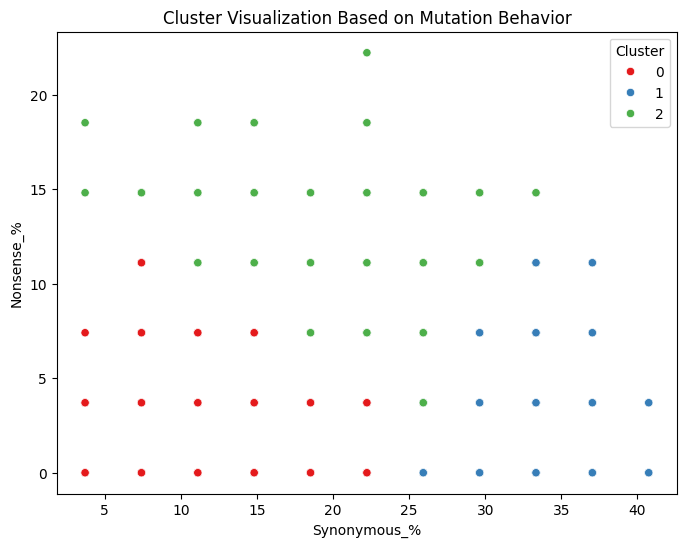

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
sns.scatterplot(
    x=df["Synonymous_%"],
    y=df["Nonsense_%"],
    hue=df["Cluster"],
    palette="Set1"
)
plt.title("Cluster Visualization Based on Mutation Behavior")
plt.show()

In [ ]:
cluster_summary = df.groupby("Cluster").mean()
cluster_summary

,Window_Index,Synonymous_%,Missense_%,Nonsense_%,GC_Content_%
Cluster,,,,,
0,2011.425099,16.571762,80.065216,3.363021,39.983939
1,1883.578035,28.660886,68.681760,2.657354,56.928388
2,1998.472086,20.013059,70.330468,9.656473,40.363478


In [ ]:
from Bio.Seq import Seq
import pandas as pd

mutation_records = []

for codon_index, codon in enumerate(codons):

    # Translate original codon
    original_translation = str(Seq(codon).translate())

    for pos in range(3):
        for nt in nucleotides:

            if nt != codon[pos]:

                mutated = list(codon)
                original_nt = codon[pos]
                mutated[pos] = nt
                mutated_codon = "".join(mutated)

                # Translate mutated codon
                mutated_translation = str(Seq(mutated_codon).translate())

                # Classify mutation
                if mutated_translation == "*":
                    mutation_type = "Nonsense"
                elif mutated_translation == original_translation:
                    mutation_type = "Synonymous"
                else:
                    mutation_type = "Missense"

                mutation_records.append({
                    "Codon_Index": codon_index,
                    "Position_in_Codon": pos + 1,
                    "Original_Nucleotide": original_nt,
                    "Mutated_Nucleotide": nt,
                    "Original_Codon": codon,
                    "Mutated_Codon": mutated_codon,
                    "Original_Codon_Translation": original_translation,
                    "Mutated_Codon_Translation": mutated_translation,
                    "Mutation_Type": mutation_type
                })

mutation_df = pd.DataFrame(mutation_records)

mutation_df.head(20)

,Codon_Index,Position_in_Codon,Original_Nucleotide,Mutated_Nucleotide,Original_Codon,Mutated_Codon,Original_Codon_Translation,Mutated_Codon_Translation,Mutation_Type
0,0,1,C,A,CGA,AGA,R,R,Synonymous
1,0,1,C,T,CGA,TGA,R,*,Nonsense
2,0,1,C,G,CGA,GGA,R,G,Missense
3,0,2,G,A,CGA,CAA,R,Q,Missense
4,0,2,G,T,CGA,CTA,R,L,Missense
5,0,2,G,C,CGA,CCA,R,P,Missense
6,0,3,A,T,CGA,CGT,R,R,Synonymous
7,0,3,A,C,CGA,CGC,R,R,Synonymous
8,0,3,A,G,CGA,CGG,R,R,Synonymous
9,1,1,T,A,TAA,AAA,*,K,Missense


In [ ]:
!pip install biopython scikit-learn seaborn

In [ ]:
from Bio import SeqIO
from Bio.Seq import Seq
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

In [ ]:
file_path = "/content/nucleotide.fasta"

record = next(SeqIO.parse(file_path, "fasta"))
cds_sequence = str(record.seq).upper()

# Ensure divisible by 3
trim_length = len(cds_sequence) - (len(cds_sequence) % 3)
cds_sequence = cds_sequence[:trim_length]

print("Sequence Length:", len(cds_sequence))
print("Total Codons:", len(cds_sequence)//3)

Sequence Length: 11787
Total Codons: 3929


In [ ]:
codons = [cds_sequence[i:i+3] for i in range(0, len(cds_sequence), 3)]

In [ ]:
nucleotides = ['A', 'T', 'C', 'G']

def simulate_codon_mutations(codon):
    original_aa = str(Seq(codon).translate())

    syn, mis, non = 0, 0, 0

    for pos in range(3):
        for nt in nucleotides:
            if nt != codon[pos]:
                mutated = list(codon)
                mutated[pos] = nt
                mutated_codon = "".join(mutated)

                mutated_aa = str(Seq(mutated_codon).translate())

                if mutated_aa == "*":
                    non += 1
                elif mutated_aa == original_aa:
                    syn += 1
                else:
                    mis += 1

    return syn, mis, non

In [ ]:
mutation_records = []

for codon_index, codon in enumerate(codons):

    original_translation = str(Seq(codon).translate())

    for pos in range(3):
        for nt in nucleotides:
            if nt != codon[pos]:

                mutated = list(codon)
                original_nt = codon[pos]
                mutated[pos] = nt
                mutated_codon = "".join(mutated)

                mutated_translation = str(Seq(mutated_codon).translate())

                if mutated_translation == "*":
                    mutation_type = "Nonsense"
                elif mutated_translation == original_translation:
                    mutation_type = "Synonymous"
                else:
                    mutation_type = "Missense"

                mutation_records.append({
                    "Codon_Index": codon_index,
                    "Position_in_Codon": pos+1,
                    "Original_Codon": codon,
                    "Mutated_Codon": mutated_codon,
                    "Original_AA": original_translation,
                    "Mutated_AA": mutated_translation,
                    "Mutation_Type": mutation_type
                })

mutation_df = pd.DataFrame(mutation_records)

mutation_df.head()

,Codon_Index,Position_in_Codon,Original_Codon,Mutated_Codon,Original_AA,Mutated_AA,Mutation_Type
0,0,1,CGA,AGA,R,R,Synonymous
1,0,1,CGA,TGA,R,*,Nonsense
2,0,1,CGA,GGA,R,G,Missense
3,0,2,CGA,CAA,R,Q,Missense
4,0,2,CGA,CTA,R,L,Missense


REVIEW-2 IMPROVEMENTS BEGIN HERE

In [ ]:
# Increased window size

window_size = 15   # 15 codons (biologically meaningful)
step_size = 3      # move 3 codons each step

windows = []

for i in range(0, len(codons) - window_size + 1, step_size):
    windows.append(codons[i:i+window_size])

print("Total Windows:", len(windows))

Total Windows: 1305


In [ ]:
# Feature extraction

def calculate_gc(sequence):
    return (sequence.count("G") + sequence.count("C")) / len(sequence) * 100

def shannon_entropy(values):
    probs = np.array(values) / np.sum(values)
    probs = probs[probs > 0]
    return -np.sum(probs * np.log2(probs))

feature_data = []

for idx, window in enumerate(windows):

    total_syn, total_mis, total_non = 0, 0, 0

    for codon in window:
        syn, mis, non = simulate_codon_mutations(codon)
        total_syn += syn
        total_mis += mis
        total_non += non

    total_mutations = total_syn + total_mis + total_non
    window_sequence = "".join(window)

    feature_data.append({
        "Window_Index": idx,
        "Synonymous_%": (total_syn/total_mutations)*100,
        "Missense_%": (total_mis/total_mutations)*100,
        "Nonsense_%": (total_non/total_mutations)*100,
        "Missense_to_Syn_Ratio": total_mis/(total_syn+1e-6),
        "GC_Content_%": calculate_gc(window_sequence),
        "Mutation_Entropy": shannon_entropy([total_syn,total_mis,total_non])
    })

df = pd.DataFrame(feature_data)

df.head()

,Window_Index,Synonymous_%,Missense_%,Nonsense_%,Missense_to_Syn_Ratio,GC_Content_%,Mutation_Entropy
0,0,16.296296,77.777778,5.925926,4.772727,42.222222,0.950125
1,1,15.555556,78.518519,5.925926,5.047619,40.000000,0.933125
2,2,18.518519,74.814815,6.666667,4.040000,44.444444,1.024185
3,3,18.518519,74.074074,7.407407,4.000000,42.222222,1.049399
4,4,17.777778,74.814815,7.407407,4.208333,42.222222,1.034314


In [ ]:
# Feature scaling

features = df.drop(columns=["Window_Index"])

scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

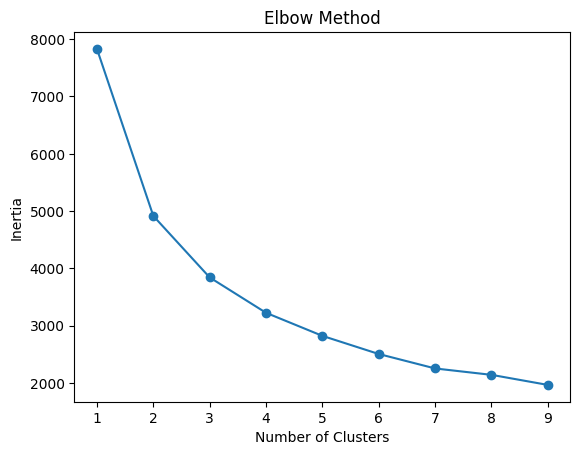

In [ ]:
# Elbow method to find optimal clusters

inertia = []

for k in range(1,10):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_features)
    inertia.append(km.inertia_)

plt.plot(range(1,10), inertia, marker='o')
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()

In [ ]:
# PCA for Dimensionality Reduction

pca = PCA(n_components=2)
pca_features = pca.fit_transform(scaled_features)

In [ ]:
# K means Clustering

kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(pca_features)

df["Cluster"] = clusters

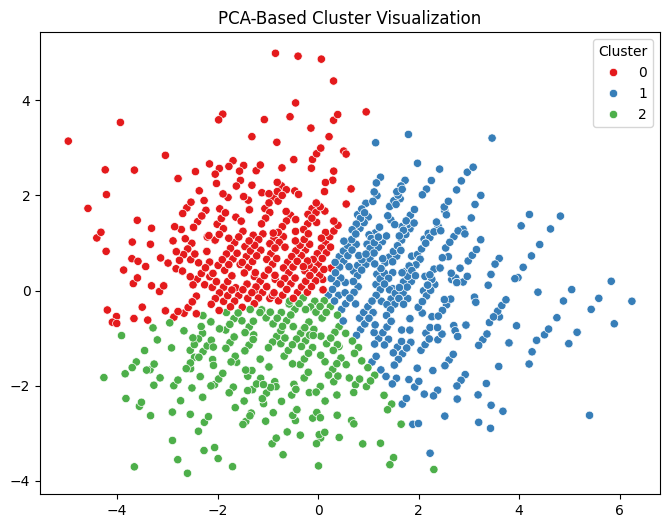

In [ ]:
plt.figure(figsize=(8,6))
sns.scatterplot(x=pca_features[:,0],
                y=pca_features[:,1],
                hue=df["Cluster"],
                palette="Set1")
plt.title("PCA-Based Cluster Visualization")
plt.show()

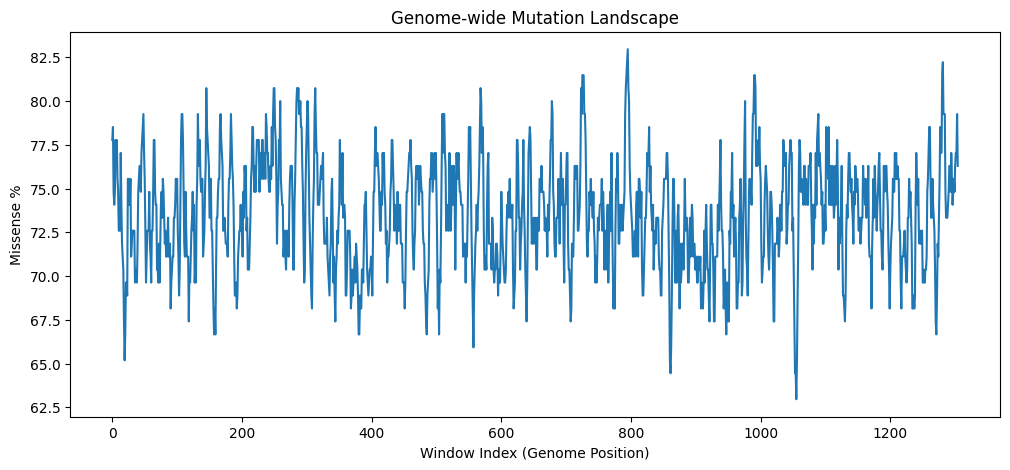

In [ ]:
plt.figure(figsize=(12,5))
plt.plot(df["Window_Index"], df["Missense_%"])
plt.xlabel("Window Index (Genome Position)")
plt.ylabel("Missense %")
plt.title("Genome-wide Mutation Landscape")
plt.show()

In [ ]:
cluster_summary = df.groupby("Cluster").mean()
cluster_summary

,Window_Index,Synonymous_%,Missense_%,Nonsense_%,Missense_to_Syn_Ratio,GC_Content_%,Mutation_Entropy
Cluster,,,,,,,
0,661.739958,23.183776,70.941978,5.874246,3.094485,46.257928,1.076255
1,679.192229,18.559418,76.429599,5.010982,4.165571,42.394910,0.959144
2,599.801749,24.308390,72.886297,2.805313,3.031775,51.221250,0.967904
